# UQpy at FrontUQ 2024
## Gaussian Process Regression 

This notebook trains a Gaussian Process (GP) as a surrogate model for the aerodynamic model defined by XFoil. The outline of this notebook is below.

1. Compute the training data using UM-Bridge calls to the XFoil model
2. Define and train separate GPs for Lift and Torque
3. Plot the results

First, we import the necessary packages. We recommend you display the UQpy logs, but it is optional and does not affect the functionality of any code.

In [1]:
import numpy as np
import UQpy as uq
import umbridge
np.random.seed(0)

import logging  # Optional, display UQpy logs
logger = logging.getLogger("UQpy")
logger.setLevel(logging.INFO)

## 1. Generate training and testing data
We define the inputs using random samples generated by UQpy and compute the outputs using UM-Bridge to call the XFoil model. Note that you can generate random inputs using the `.rvs` method in UQpy or use a more sophisticated [sampling scheme](https://uqpyproject.readthedocs.io/en/latest/sampling/index.html). Latin hypercube sampling is shown below.

Once all `n` samples are generated, we treat the first half as training data the surrogate will train on and the second half as a dataset to test the performance of the surrogate.

In [2]:
# define inputs using UQpy
marginals = [
    uq.Normal(0.0, 0.1),
    uq.Normal(500_000, 2_500),
    uq.Normal(0.3, 0.015),
    uq.Normal(0.7, 0.021),
    uq.Normal(0, 0.08),
]
distribution = uq.JointIndependent(marginals)
n = 100
# x = distribution.rvs(n)  # random samples
x = uq.LatinHypercubeSampling(distribution, n, random_state=0).samples  # LHS samples

# compute outputs using UM-Bridge
model = umbridge.HTTPModel("http://localhost:61855", "forward")
outputs = np.zeros((n, 4))
for i in range(n):
    if i % (n // 10) == 9:
        print(f"UM-Bridge Model Evaluations: {i + 1} / {n}")
    model_input = [x[i].tolist()]  # model input is a list of lists
    outputs[i] = model(model_input)[0]
    
# split into training and testing data sets
split = int(n * 0.5)
x_train = x[0:split]
lift_train = outputs[0:split, 0]
torque_train = outputs[0:split, 3]
x_test = x[split:]
lift_test = outputs[split:, 0]
torque_test = outputs[split:, 3]

[INFO] - 2024-09-17 11:23:09,817 - UQpy: Running Latin Hypercube sampling...
[INFO] - 2024-09-17 11:23:09,822 - Successful execution of LHS design.


UM-Bridge Model Evaluations: 10 / 100
UM-Bridge Model Evaluations: 20 / 100
UM-Bridge Model Evaluations: 30 / 100
UM-Bridge Model Evaluations: 40 / 100
UM-Bridge Model Evaluations: 50 / 100
UM-Bridge Model Evaluations: 60 / 100
UM-Bridge Model Evaluations: 70 / 100
UM-Bridge Model Evaluations: 80 / 100
UM-Bridge Model Evaluations: 90 / 100
UM-Bridge Model Evaluations: 100 / 100


## 2. Train Gaussian Process Regressions

We assume that the Lift and Torque outputs are independent, so we can construct separate Gaussian Processes for each. Each GP takes in all 5 inputs and predicts a scalar value. Training a GP may take a few minutes depending on model parameters. 

Once the GPs are trained, we compute their mean and standard deviation predictions on the testing data.

In [3]:
# define and train gaussian process regression
kernel = uq.utilities.RBF()
regression_model = uq.LinearRegression()
optimizer = uq.MinimizeOptimizer()
gpr_lift = uq.GaussianProcessRegression(
    kernel,
    [1] * 7,
    regression_model=regression_model,
    optimizer=optimizer,
    optimizations_number=10,
    noise=True,
)
gpr_torque = uq.GaussianProcessRegression(
    kernel,
    [1] * 7,
    regression_model=regression_model,
    optimizer=optimizer,
    optimizations_number=10,
    noise=True,
)
gpr_lift.fit(x_train, lift_train)
gpr_torque.fit(x_train, torque_train)

# compute GPR predictions
lift_prediction, lift_std = gpr_lift.predict(x_test, return_std=True)
torque_prediction, torque_std = gpr_torque.predict(x_test, return_std=True)

[INFO] - 2024-09-17 11:24:54,226 - UQpy: Running gpr.fit
[INFO] - 2024-09-17 11:24:54,741 - UQpy: gpr fit complete.
[INFO] - 2024-09-17 11:24:54,742 - UQpy: Running gpr.fit
[INFO] - 2024-09-17 11:24:55,701 - UQpy: gpr fit complete.


## 3. Plot results

All the hard work is done! We computed our training data, defined and trained the surrogates, then used the surrogates to predict new results.

The rest of this notebook compares the GPs to XFoil on the testing data that *was not* used during model training.

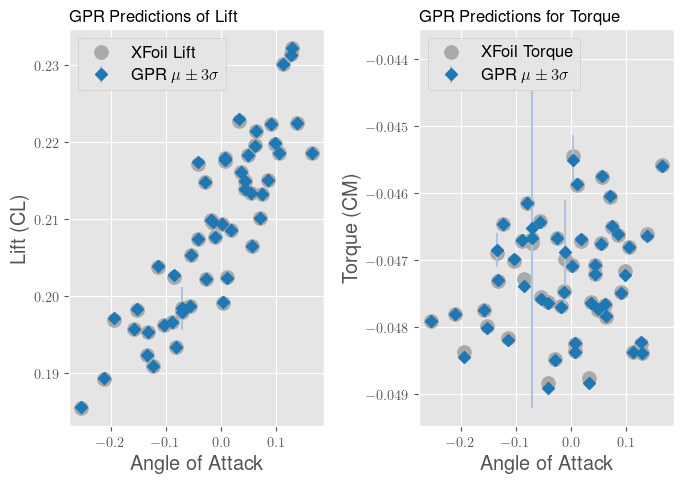

In [4]:
import matplotlib.pyplot as plt

plt.style.use(["ggplot", "surg.mplstyle"])

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(7, 5))
ax0.scatter(
    x_test[:, 0],
    lift_test,
    label="XFoil Lift",
    color="darkgray",
    marker="o",
    s=10**2,
)
ax0.errorbar(
    x_test[:, 0],
    lift_prediction[:, 0],
    yerr=3 * lift_std,
    label="GPR $\mu \pm 3\sigma$",
    color="tab:blue",
    ecolor="lightsteelblue",
    marker="D",
    linestyle="none",
)
ax0.set_title("GPR Predictions of Lift")
ax0.set(xlabel="Angle of Attack", ylabel="Lift (CL)")
ax0.legend(loc="upper left", framealpha=1.0)

ax1.scatter(
    x_test[:, 4],
    torque_test,
    label="XFoil Torque",
    color="darkgray",
    marker="o",
    s=10**2,
)
ax1.errorbar(
    x_test[:, 4],
    torque_prediction[:, 0],
    yerr=3 * torque_std,
    label="GPR $\mu \pm 3\sigma$",
    color="tab:blue",
    ecolor="lightsteelblue",
    marker="D",
    linestyle="none",
)
ax1.set_title("GPR Predictions for Torque")
ax1.set(xlabel="Flap Deflection", ylabel="Torque (CM)")
ax1.legend(loc="upper left", framealpha=1.0)
fig.tight_layout()
plt.show()

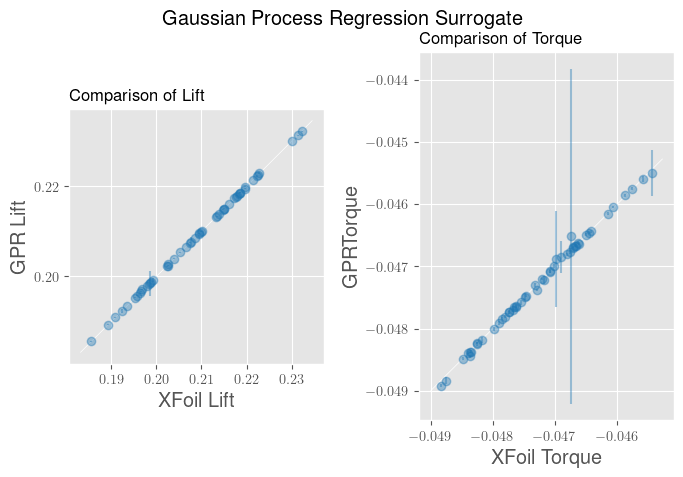

In [5]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(7, 5))
ax0.errorbar(
    lift_test,
    lift_prediction[:, 0],
    yerr=3 * lift_std,
    color="tab:blue",
    marker="o",
    alpha=0.4,
    linestyle="none",
)
ax1.errorbar(
    torque_test,
    torque_prediction[:, 0],
    yerr=3 * torque_std,
    color="tab:blue",
    marker="o",
    alpha=0.4,
    linestyle="none",
)
# format the plots
ax0.set_title("Comparison of Lift")
ax0.set(xlabel="XFoil Lift", ylabel="GPR Lift")
ax1.set_title("Comparison of Torque")
ax1.set(xlabel="XFoil Torque", ylabel="GPRTorque")
ax0.set_yticks(ax0.get_xticks())
for ax in (ax0, ax1):
    xlim = ax.get_xlim()
    ax.plot(xlim, xlim, color="white", linewidth=0.5, zorder=1)
    ax.set_aspect("equal")
fig.tight_layout()
fig.suptitle("Gaussian Process Regression Surrogate")
plt.show()